In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [3]:
def get_init_counts(volume):
        n_ribo = (7.280245377599019e21*(1 + 1.3322199014570686e-12/
            volume**0.6454883435592754)*volume**0.6971221467560254)/(-5000*(1 +
             1.3322199014570686e-12/volume**0.6454883435592754) + 
          1.3525663798553437e-6/volume**0.6454883435592754)

        n_prot = 7.466918335998994e18*(volume**0.6971221467560254)
        
        return n_ribo, n_prot #volume

def get_div_time(volume):
    if True:
        return 1.4881390043125451e-8/volume**0.6454883435592754
    else:
        return 10000.
    
get_init_counts(1e-18)[0]/get_init_counts(1e-18)[1]
    

0.0027321103566716656

In [4]:
# fraction of ribosomal capacity invested in ribosome production
gamma = 0.0138172 #unitless / scales with size

#specific decay rates per second
ribo_decay = 6.205e-6 # 1/s
prot_decay = 6.205e-6 # 1/s




# transcript processing rates [bp/s]
r_R = 50 #bp/s
r_P = 50 #bp/s

# average transcript length 
l_R = 5000 #bp
l_P = 975 #bp


# steady-state
#ribo_decay = gamma * r_R / l_R # 1/s
#prot_decay = (1-gamma)*r_P/ l_P * get_init_counts(1e-18)[0]/get_init_counts(1e-18)[1] # 1/s



LHS = np.array([[1,1,1,0],
               [0,0,0,1]])

RHS = np.array([[2,1,0,0],
                [0,1,0,0]])


#stoichiometric matrix
S = RHS - LHS   


def reaction_rates(volume, X, 
                   mu_ribo_synth= gamma*r_R/l_R, #average kinetic rate of ribosomal synthesis [1/s]
                   mu_prot_synth= (1-gamma)*r_P/l_P, #average kinetic rate of protein synthesis [1/s]
                   mu_ribo_decay= ribo_decay,  #constant decay rate for ribosomes [1/s]
                   mu_prot_decay= prot_decay): #constant decay rate for proteins [1/s]
    
    #vecrtor of rates
    mu_vector = np.array([mu_ribo_synth, mu_prot_synth, mu_ribo_decay, mu_prot_decay])
    scaled_rates = np.power(X.repeat(LHS.shape[1],1),LHS).prod(axis=0)
    #if np.any(scaled_rates < 0):
    #    print(scaled_rates)
    #    print(X)
    #    raise
    return mu_vector * scaled_rates

def dZ_dt(state, 
          t=0, #[s]
          volume=1e-18, t_division=1e10): # [m3]
    
    if np.any(np.isnan(state)):
        print(t)
        raise
    
    Z = state.reshape(2*LHS.shape[0]+1, LHS.shape[0])
    
    #print(Z)
    
    #expected counts [unitless]
    phi = np.atleast_2d(Z[0]).T 
    
    
    F = reaction_rates(volume=volume, X=phi)

    #assert (np.all(np.diag(F) >= 0))
    E = S @ np.sqrt(np.diag(F))
    J = ( (1/phi @ np.atleast_2d(F) ) * LHS).T
    A = S @ J
    
    V = Z[1:A.shape[0]+1]
    G = Z[A.shape[0]+1:]
    
    
    phidot = S @ F
    Vdot = A @ V + V @ A.T + E @ E.T
    
    Gdot = A @ G
    #print(Gdot)


    
    ode_list = np.vstack((phidot, Vdot, Gdot)).reshape(-1)

    
    return ode_list


In [31]:
class Trajectory:
    def get_init_counts(self, volume):
        n_ribo = (7.280245377599019e21*(1 + 1.3322199014570686e-12/
            volume**0.6454883435592754)*volume**0.6971221467560254)/(-5000*(1 +
             1.3322199014570686e-12/volume**0.6454883435592754) + 
          1.3525663798553437e-6/volume**0.6454883435592754)

        n_prot = 7.466918335998994e18*(volume**0.6971221467560254)
        
        return n_ribo, n_prot #volume

    def get_div_time(self, volume):
        if True:
            return 1.4881390043125451e-8/volume**0.6454883435592754
        else:
            return 10000.
        
        #n_ribo, n_prot = volume, volume
        #return n_ribo, n_prot

    def __init__(self, 
                 volume   = 1e-18, 
                 iterations=100000,
                 cov_scaling = 0.01,
                 division = True):
        
        self.final_time = 200000#00.
        
        self.volume     = volume
        self.iterations = iterations
        self.division = division
        self.cov_scaling = cov_scaling
        
        init_counts = np.array(self.get_init_counts(volume))
        n_species = len(init_counts)
        
        init_cov    = np.eye(n_species) * self.cov_scaling * init_counts**2
        global_init = np.vstack([init_counts.reshape(1,n_species), init_cov, np.identity(n_species)]).astype('float64')
        
        
        # division time in terms of array index
        div_time = int(self.iterations/self.final_time * self.get_div_time(self.volume))
        
        # from 0 to final_time, 
        T = np.linspace(0, self.final_time, self.iterations)
        #epsilon = self.final_time/self.iterations
        
        
        if self.division:
            n_generations = int(np.ceil(self.final_time/self.get_div_time(self.volume)))

            #divides mean counts by 2 in the beginning of each new generation
            division_matrix = np.vstack((np.ones((1,n_species))*1, np.ones((n_species, n_species))*0.25, np.ones((n_species, n_species))))

            self.generations = []

            for gen_id in range(n_generations):

                #make generations either as long as division time or as the remaining time steps before final_time
                t_final = min(self.get_div_time(self.volume), int(self.final_time - gen_id*self.get_div_time(self.volume)))
                T_gen = np.linspace(0, t_final, self.iterations)

                if gen_id == 0:
                    y0 = global_init.reshape(-1)
                else:
                    #restart counts, divide variance, keep G matrix intact


                    y0 = np.vstack([init_counts.reshape(1, n_species), 
                                    gen[-1, 1:1+n_species, :] / 8 + gen[-1,0,:] / 4,
                                    gen[-1, 1+n_species: , :]]).reshape(-1)

    #                y0 = (gen[-1,:,:] * division_matrix).reshape(-1)

                gen = odeint(dZ_dt, y0=y0, t=T_gen, args=(volume,self.get_div_time(self.volume))).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])
                self.generations.append(gen)
                #print(gen[-1,:,:])


            solved_odes_multigen = np.vstack(self.generations)
            solved_odes = np.vstack(self.generations)
        else:
            solved_odes = odeint(dZ_dt, y0=global_init.reshape(-1), t=T, args=(volume,self.get_div_time(self.volume))).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])
        
        
        self.X_t = solved_odes[:,0,:]
        self.V_t = solved_odes[:,1:n_species+1,:]
        self.G_t = solved_odes[:,n_species+1:, :]
        self.cov_t = self.V_t[0] @ self.G_t.transpose(0,2,1)

        self.var_ribo = self.V_t[:,0,0]
        self.var_prot = self.V_t[:,1,1]
        self.cov_riboprot = self.V_t[:,0,1]

        self.cov_ribo_over_time = self.cov_t[:,0,0]
        self.cov_prot_over_time = self.cov_t[:,1,1]
        self.cov_riboprot_over_time = self.cov_t[:,1,0]

        self.rho_ribo = np.array([self.cov_ribo_over_time[t]/(np.sqrt(self.var_ribo[0])*np.sqrt(self.var_ribo[t])) for t in range(0,iterations)])
        self.rho_prot = np.array([self.cov_prot_over_time[t]/(np.sqrt(self.var_prot[0])*np.sqrt(self.var_prot[t])) for t in range(0,iterations)])
        self.rho_riboprot = np.array([self.cov_riboprot_over_time[t]/(np.sqrt(self.cov_riboprot[0])*np.sqrt(self.cov_riboprot[t])) for t in range(0,iterations)])
        
        if any(self.rho_ribo < 1e-3):
            self.mi_ribo = 0.721348*self.rho_ribo**2
        else:    
            self.mi_ribo = -0.5*np.log2(1-self.rho_ribo**2)
        
        if any(self.rho_prot < 1e-3):
            self.mi_prot = 0.721348*self.rho_prot**2
        else:    
            self.mi_prot = -0.5*np.log2(1-self.rho_riboprot**2) 
        
        if any(self.rho_riboprot < 1e-3):
            self.mi_riboprot = 0.721348*self.rho_riboprot**2
        else:    
            self.mi_riboprot = -0.5*np.log2(1-self.rho_riboprot**2) 
        
        
        if self.rho_ribo[div_time] < 1e-3:
            self.mi_ribo_div = 0.721348*self.rho_ribo[div_time]**2
        else:
            self.mi_ribo_div = -0.5*np.log2(1-self.rho_ribo[div_time]**2)
        
        if self.rho_prot[div_time] < 1e-3:
            self.mi_prot_div = 0.721348*self.rho_prot[div_time]**2
        else:
            self.mi_prot_div = -0.5*np.log2(1-self.rho_prot[div_time]**2)
        
        
        if self.rho_riboprot[div_time] < 1e-3:
            self.mi_riboprot_div = 0.721348*self.rho_riboprot[div_time]**2
        else:
            self.mi_riboprot_div = -0.5*np.log2(1-self.rho_riboprot[div_time]**2)
        
        
        #
        #self.mi_prot = 0.5*self.rho_prot**2


/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less


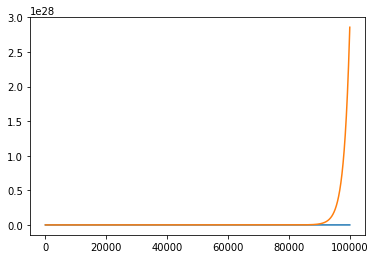

In [6]:
traj = Trajectory(volume=1e-18, division=False)
#traj = Trajectory(volume=1e-18)

#print(np.linspace(0, traj.final_time, traj.iterations))
#print('banana')
plt.plot(traj.X_t[:,0])
#plt.yscale('log')
#print(np.linspace(0, traj.final_time, traj.iterations))
#print(traj.get_div_time(traj.volume))

plt.plot(traj.V_t[:,0,0])
#plt.yscale('log')
#plt.xscale('log')

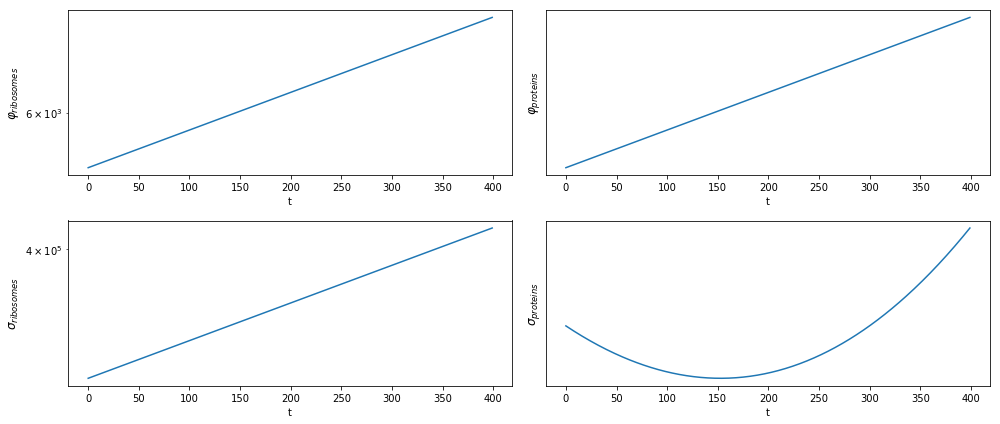

In [25]:
range_end = 400

fig, axes = plt.subplots(2,2, figsize=(14,6))



axes[0,0].plot(range(range_end),traj.X_t[0:range_end,0])
axes[0,0].set_ylabel(r'$\varphi_{ribosomes}$', size=12)
axes[0,0].set_xlabel(r't')
axes[0,0].set_yscale('log')

axes[0,1].plot(range(range_end),traj.X_t[0:range_end,1])
axes[0,1].set_ylabel(r'$\varphi_{proteins}$', size=12)
axes[0,1].set_xlabel(r't')
axes[0,1].set_yscale('log')

axes[1,0].plot(range(range_end),traj.V_t[0:range_end,0,0])
axes[1,0].set_ylabel(r'$\sigma_{ribosomes}$', size=12)
axes[1,0].set_xlabel(r't')
axes[1,0].set_yscale('log')

axes[1,1].plot(range(range_end),traj.V_t[0:range_end,1,1])
axes[1,1].set_ylabel(r'$\sigma_{proteins}$', size=12)
axes[1,1].set_xlabel(r't')
axes[1,1].set_yscale('log')


plt.tight_layout()
plt.show()

In [16]:
traj.X_t[:,0].shape
# range_end = 2000000

# fig, axes = plt.subplots(2,2, figsize=(7,6))



(100000,)

In [ ]:
range_end = 1000000

plt.plot(range(range_end),traj.X_t[0:range_end,0])
plt.ylabel(r'$V_{prot}$')
plt.xlabel(r't')
plt.show()
    

In [26]:
traj.generations[0]

AttributeError: 'Trajectory' object has no attribute 'generations'

In [27]:
volumes = np.logspace(-20,-15,20)
trajectories_by_volume = [Trajectory(volume=v, division=False) for v in volumes]

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: RuntimeWarning: invalid value encountered in less
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in log2


In [43]:
matrix_length = 20

volumes = np.logspace(-20,-15,matrix_length)
scaling_factors = np.logspace(-2,10,matrix_length)
ribo_matrix = np.zeros((matrix_length,matrix_length))
prot_matrix = np.zeros((matrix_length,matrix_length))

for i,f in enumerate(scaling_factors):
    for j,v in enumerate(volumes):
        traj_ij = Trajectory(volume=v, division=False, cov_scaling=f)
        ribo_matrix[i,j] =  traj_ij.mi_ribo_div
        prot_matrix[i,j] =  traj_ij.mi_prot_div
        

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in less
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in log2
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in log2


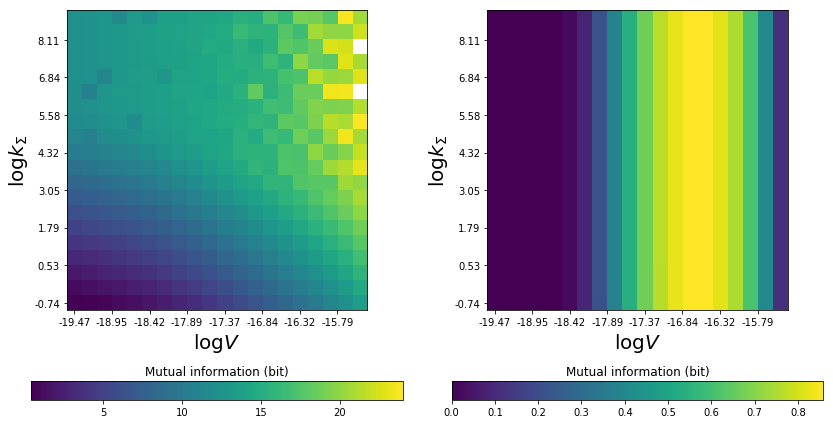

In [91]:
fig, axes = plt.subplots(2,2, figsize=(12,6),
                        gridspec_kw = {'height_ratios':[16, 1]})


ribo_hm = axes[0,0].imshow(ribo_matrix.T, origin='lower')
prot_hm = axes[0,1].imshow(prot_matrix.T, origin='lower')



axes[0,0].set_xticklabels(np.round((np.log10(volumes)),2)[::2])
axes[0,1].set_xticklabels(np.round((np.log10(volumes)),2)[::2])

axes[0,0].set_yticklabels(np.round((np.log10(scaling_factors)),2)[::2])
axes[0,1].set_yticklabels(np.round((np.log10(scaling_factors)),2)[::2])

# p0 = ax[0].get_position().get_points().flatten()
# p1 = ax[1].get_position().get_points().flatten()
# p2 = ax[2].get_position().get_points().flatten()
# ax_cbar = fig.add_axes([p0[0], 0, p1[2]-p0[0], 0.05])
# plt.colorbar(ribo_hm, cax=ax_cbar, orientation='horizontal')

axes[0,0].set_xlabel(r'$\log{V}$', size=20)
axes[0,1].set_xlabel(r'$\log{V}$', size=20)

axes[0,0].set_ylabel(r'$\log{k_{\Sigma}}$', size=20)
axes[0,1].set_ylabel(r'$\log{k_{\Sigma}}$', size=20)

cb_ribo = plt.colorbar(ribo_hm, axes[1,0], orientation='horizontal')
cb_prot = plt.colorbar(prot_hm, axes[1,1], orientation='horizontal')

cb_ribo.ax.set_title('Mutual information (bit)')
cb_prot.ax.set_title('Mutual information (bit)')

plt.tight_layout()
plt.show()

In [92]:
ribo_matrix

array([[ 0.43271564,  1.08796371,  2.00292364,  3.01669001,  4.05722268,
         5.10422577,  6.15266747,  7.20107087,  8.24788084,  9.28744079,
        10.29730973, 11.19772168, 11.83000411, 12.10598656, 12.19886071,
        12.21928473, 12.24437669, 12.22793041, 12.22934875, 12.22330336],
       [ 0.60237725,  1.35981672,  2.31961676,  3.34609138,  4.38976768,
         5.43750782,  6.48452564,  7.53450615,  8.58109011,  9.62028435,
        10.62663309, 10.65392739, 12.11744904, 12.3969035 , 10.8295726 ,
        12.49312391, 12.50022807, 12.53546702, 12.50156246, 12.50635571],
       [ 0.81788847,  1.66262949,  2.65427747,  3.68921862,  4.73490992,
         5.78312382,  6.83182688,  7.88017147,  8.92651684,  9.9641514 ,
        10.9702588 , 11.84399015, 12.43201011, 12.68164647, 12.7481778 ,
        11.15637632, 12.76133426, 12.77318032, 12.83018387, 12.77183328],
       [ 1.08472132,  1.99901771,  3.01258888,  4.05307759,  5.10008882,
         6.14860801,  7.19736605,  8.24564541,  

In [28]:


mi_ribo_div_by_size = [trajectories_by_volume[i].mi_ribo_div for i in range(len(volumes))]
mi_prot_div_by_size = [trajectories_by_volume[i].mi_prot_div for i in range(len(volumes))]
mi_riboprot_div_by_size = [trajectories_by_volume[i].mi_riboprot_div for i in range(len(volumes))]

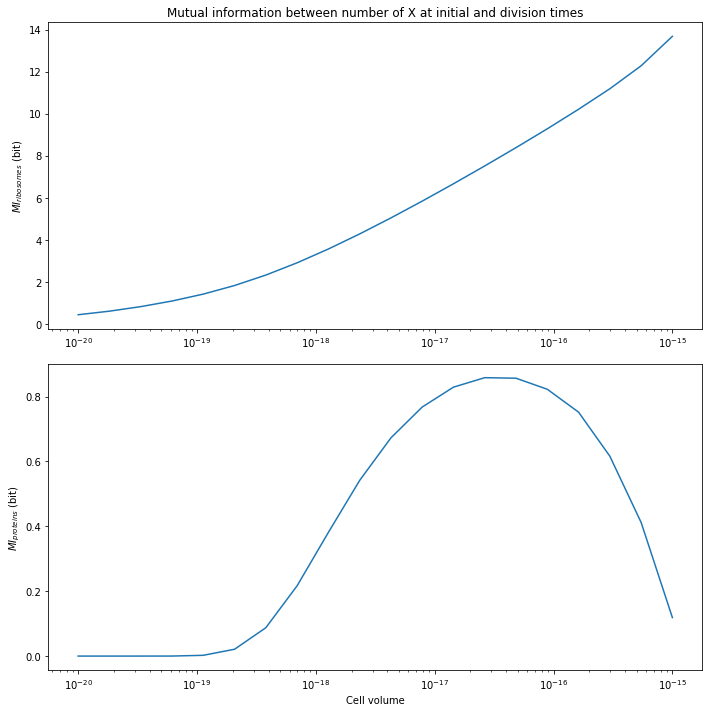

In [29]:
fig, axes = plt.subplots(2, sharex=False, figsize=(10,10))
axes[0].plot(volumes,mi_ribo_div_by_size)
axes[0].set_xscale('log')
axes[1].plot(volumes,mi_prot_div_by_size)
axes[1].set_xscale('log')
#axes[2].plot(volumes,mi_riboprot_div_by_size)
axes[1].set_xscale('log')
axes[1].set_xlabel('Cell volume')
axes[0].set_ylabel(r'$MI_{ribosomes}$ (bit)')
axes[1].set_ylabel(r'$MI_{proteins}$ (bit)')
axes[0].set_title('Mutual information between number of X at initial and division times')

plt.tight_layout()
plt.show()

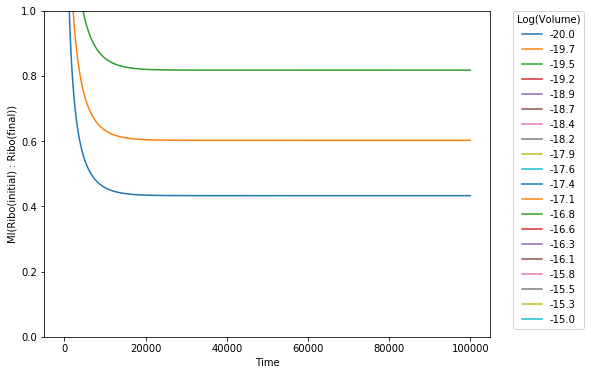

In [30]:
plt.figure(figsize=(8,6))
for i,traj in enumerate(trajectories_by_volume):
    plt.plot(traj.mi_ribo, label='%0.1f'%np.log10(traj.volume))
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('MI(Ribo(initial) : Ribo(final))')
plt.xlabel(r'Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Log(Volume)')
#plt.xlim([-1,1])
plt.ylim([0,1])
plt.show()

In [ ]:
print(trajectories_by_volume[0].V_t)
print(stack_overflow_traj.V_t)
#stack_overflow_traj = trajectories_by_volume[0]

In [ ]:
#trajectories_by_volume[0].X_t[:,0]
plt.plot(trajectories_by_volume[0].X_t[:,0])
#plt.yscale('log')
plt.show()

In [ ]:
logsp = np.logspace(-21,-15,50)
plt.plot(logsp, get_init_counts(logsp)[0])
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(-1e4, 1e4)
plt.show()

In [ ]:
def get_div_time(volume):
    return 1.4881390043125451e-8/volume**0.6454883435592754

In [ ]:
plt.plot(logsp,get_div_time(logsp))
plt.xscale('log')
plt.yscale('log')

In [ ]:
(3 - 5.9 % 3) < 0.1

In [ ]:
n_species = 2 

In [ ]:
np.array(
    
    [[],
          [],
          [],
          []])